In [108]:
import numpy as np
import sys, os, shutil
import pandas as pd
import collections as cl
import itertools as it
import timeit
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy as cp
import pyprojroot as pr
import scipy.stats as scs
from sklearn.model_selection import StratifiedShuffleSplit
import scipy as sc

In [109]:
#Change directory
os.chdir(pr.here("./Data"))
os.getcwd()

'C:\\Users\\yche465\\Desktop\\AIM 1\\Codes\\PrEP-Traj-Clustering\\Data'

In [110]:
Name=['Emory','WG']

In [111]:
#Select a user name
User=Name[0]
print(User)

Emory


## Prepare variables describing the PrEP use trend

Create a data matrix object with the following two fields: <br> 1) the total duration spent in suboptimal sero-protection;<br> 2) the number of PrEP protection interval

In [112]:
#Import PMC and SeroProtect matrices
os.chdir(pr.here("./Data"))
PMC = np.loadtxt('PMC_13k.txt', usecols=range(103), delimiter=",")
SeroProtect = np.loadtxt('SeroProtect_13k.txt', usecols=range(104), delimiter=",")
orig_size=len(SeroProtect)

In [113]:
real_ID=SeroProtect[:,0].astype('int64')

In [114]:
def intv_attr(PMC):
    # Create the matrix of suboptimal sero-protection (i.e., PMC<0.57)
    SubProtect=PMC<4/7
    #Create the following time series arrays:
    ## possible PrEP cessation start time (in week)
    ## possible PrEP cessation end time (in week)
    ## possible PrEP use interval start time (in week)
    ## possible PrEP use iterval end time (in week)
    CESS_START=[]
    CESS_END=[]
    PrEP_START=[]
    PrEP_END=[]
    
    CHECK_PrEP_Init=[]
    CHECK_PrEP_30d_2017=[]

    for k in range(len(SubProtect)):
        cess_start=[]
        prep_start=[0]
        cess_end=[]
        prep_end=[]
        for i in range(1,103):
            if SubProtect[k][i]==True and SubProtect[k][i-1]==False:
                cess_start.append(i)
                prep_end.append(i)

            elif SubProtect[k][i]==False and SubProtect[k][i-1]==True:
                cess_end.append(i)
                prep_start.append(i)

        CESS_START.append(cess_start)
        PrEP_START.append(prep_start)
        CESS_END.append(cess_end)
        PrEP_END.append(prep_end)

    #set the Week 103 as the end point of any unclosed PrEP use interval 
    for i in range(len(SubProtect)):
        if len(PrEP_START[i])>len(PrEP_END[i]):
            PrEP_END[i].append(103)

    for i in range(len(SubProtect)):   
        #if more cessation start date than end date, then set the Week 103 as the end point of any unclosed 
        #cessation interval 
        if len(CESS_START[i])>len(CESS_END[i]):
            CESS_END[i].append(103)
        
        #else if more cessation end date than start date, then set the Week 0 as the start point of 
        #any unclosed cessation interval 
        elif len(CESS_START[i])<len(CESS_END[i]):
            CESS_START[i].insert(0,0)
            print("Check if PrEP init record <30 day supply: subject ID=",real_ID[i], "/row ID=",i)
            CHECK_PrEP_Init.append(i)
        #else if equal number of cessation start and end dates & the first end date predate the first start date 
        # then add Week 0 as the first start date and Week 103 as the last end date
        elif len(CESS_START[i])==len(CESS_END[i]) and len(CESS_START[i])>0 and CESS_START[i][0]>CESS_END[i][0]:
            CESS_START[i].insert(0,0)
            CESS_END[i].append(103)
            print("Check if PrEP init record <30 day supply: subject ID=",real_ID[i],"/row ID=",i)
            CHECK_PrEP_Init.append(i)
        #else if it is cessation all the way through the entire follow-up period (i.e., no initial start and end dates 
        #but subpoptimal sero-protection time series is >0) then add Week 0 and 103 as the start and end dates, respectively
        elif len(CESS_START[i])==0 and len(CESS_START[i])==0 and sum(SubProtect[i])>0:
            CESS_START[i].insert(0,0)
            CESS_END[i].append(103)
            print("Check if the subject has at least one >=30 day PrEP record in 2017: subject ID=",real_ID[i],"/row ID=",i)
            CHECK_PrEP_30d_2017.append(i)
    return CESS_START, CESS_END, PrEP_START, PrEP_END, CHECK_PrEP_Init, CHECK_PrEP_30d_2017

In [115]:
CESS_START,CESS_END,PrEP_START,PrEP_END, CHECK_PrEP_Init, CHECK_PrEP_30d_2017 = intv_attr(PMC)

In [116]:
#Check if the subject's PrEP initiation record <30 day supply
#Check if the subject has at least one >=30 day PrEP record in 2017
#Please feel free to change '12' in real_ID to any other row ID shown in 'CHECK_PrEP_Init' or 'CHECK_PrEP_30d_2017'
prescript_rec=pd.read_csv("syndata_13k.csv").astype({'ID':'int'})
prescript_rec.loc[prescript_rec['ID']==real_ID[12],:]

,ID,PrEP_Start,PrEP_End
21,351,10/13/2023,01/30/2025


In [117]:
#Create list object: the duration of 1st, 2nd, 3rd PrEP protective intervals
IntervalLen_1=[None]*orig_size
IntervalLen_2=[None]*orig_size
IntervalLen_3=[None]*orig_size
for i in range(orig_size):
    IntervalLen_1[i]=PrEP_END[i][0]-PrEP_START[i][0]
    if(len(PrEP_START[i])>1):
        IntervalLen_2[i]=PrEP_END[i][1]-PrEP_START[i][1]
    if(len(PrEP_START[i])>2):
        IntervalLen_3[i]=PrEP_END[i][2]-PrEP_START[i][2]    

In [118]:
#Create list object: the total duration spent in sub-optimal sero-protection 
SubProtect=PMC<4/7
Total_SubP_Dur=np.array([sum(SubProtect[i]) for i in range(orig_size)])
#Create list object: the number of the number of sero-protection interval
Num_Protect_Int=np.array([len(PrEP_START[i]) for i in range(orig_size)])

## Descriptive statistics: original dataset

In [119]:
os.chdir(pr.here("./Data"))
#Import person-level covariates
PERSON_DATA=pd.read_csv("PersonVars.csv")

#Check whether the ID in the peron-level covariate datasets is the same as the 
print(min(SeroProtect[:,0]==PERSON_DATA['ID']))

#if TRUE, then append the two PrEP trajectory related variables
if min(SeroProtect[:,0]==PERSON_DATA['ID']):
    PERSON_DATA["Dur_subopt"]=Total_SubP_Dur
    PERSON_DATA["Num_protect_interval"]=Num_Protect_Int
    PERSON_DATA["IntervalLen_1"]=IntervalLen_1
    PERSON_DATA["IntervalLen_2"]=IntervalLen_2
    PERSON_DATA["IntervalLen_3"]=IntervalLen_3

True


In [120]:
colnames=PERSON_DATA.columns.values.tolist()
colnames.remove('ID')
cat_vars=list(colnames[i] for i in [1,3])
cont_vars=list(var for var in colnames if var not in cat_vars)

In [121]:
cat_vars

['Primary_payer', 'Pharmacy_type']

In [122]:
cont_vars

['Age_at_init',
 'Average_copay',
 'Dur_subopt',
 'Num_protect_interval',
 'IntervalLen_1',
 'IntervalLen_2',
 'IntervalLen_3']

### _Univariate distributions_

In [123]:
#univariate distributions for continuous variables
univ_mean=[]
univ_SD=[]
univ_median=[]
univ_IQR25=[]
univ_IQR75=[]
for i in cont_vars:
    univ_mean.append(round(np.nanmean(PERSON_DATA[i]),1))
    univ_SD.append(round(np.nanstd(PERSON_DATA[i]),1))
    univ_median.append(round(np.nanmedian(PERSON_DATA[i]),1))
    univ_IQR25.append(round(np.nanquantile(PERSON_DATA[i], 0.25),1))
    univ_IQR75.append(round(np.nanquantile(PERSON_DATA[i], 0.75),1))

In [124]:
cont_vars_label=["Age at PrEP initiation",
                 "Monthly average copay",
                 "Total time under sub-optimal PrEP protection",
                 "Number of PrEP protective interval",
                 "Length of 1st PrEP protective interval",
                 "Length of 2nd PrEP protective interval",
                 "Length of 3rd PrEP protective interval"]

univar_cont_orig=pd.DataFrame({"Attribute":cont_vars_label,
                            "Mean":univ_mean,
                            "SD": univ_SD,
                            "Median": univ_median,
                            "IQR:25%": univ_IQR25,
                            "IQR:75%": univ_IQR75})

In [125]:
univar_cont_orig

,Attribute,Mean,SD,Median,IQR:25%,IQR:75%
0,Age at PrEP initiation,35.9,8.9,35.0,29.0,42.0
1,Monthly average copay,20.1,20.1,13.8,5.7,27.9
2,Total time under sub-optimal PrEP protection,65.9,26.2,73.0,46.0,91.0
3,Number of PrEP protective interval,1.5,0.8,1.0,1.0,2.0
4,Length of 1st PrEP protective interval,26.3,21.2,17.0,11.0,35.0
5,Length of 2nd PrEP protective interval,23.1,17.4,17.0,10.0,32.0
6,Length of 3rd PrEP protective interval,16.9,12.1,13.0,8.0,23.0


In [126]:
#Univariate distribution for categorical variables
if len(cat_vars)<3:
    cat_vars.append("Num_protect_interval")
cat_vars_label=["Primary payer","Pharmacy type","Number of PrEP protective interval"]
univar_cat_orig=pd.DataFrame()
for i in range(len(cat_vars)):
    freq=dict(cl.Counter(PERSON_DATA[cat_vars[i]]))
    freq_tab = pd.DataFrame(list(freq.items()),columns = ["Level",'N']).sort_values(by="Level") 
    freq_tab['%']=np.around(freq_tab['N']/len(Num_Protect_Int)*100,1)
    freq_tab.insert(0,"Variable",cat_vars_label[i])
    freq_tab.index=[''] * len(freq)
    univar_cat_orig=pd.concat([univar_cat_orig,freq_tab])
cat_vars.remove("Num_protect_interval")

In [127]:
univar_cat_orig

,Variable,Level,N,%
,Primary payer,0,10464,80.5
,Primary payer,1,1895,14.6
,Primary payer,2,641,4.9
,Pharmacy type,0,6497,50.0
,Pharmacy type,1,6503,50.0
,Number of PrEP protective interval,1,8410,64.7
,Number of PrEP protective interval,2,2920,22.5
,Number of PrEP protective interval,3,1234,9.5
,Number of PrEP protective interval,4,383,2.9
,Number of PrEP protective interval,5,50,0.4


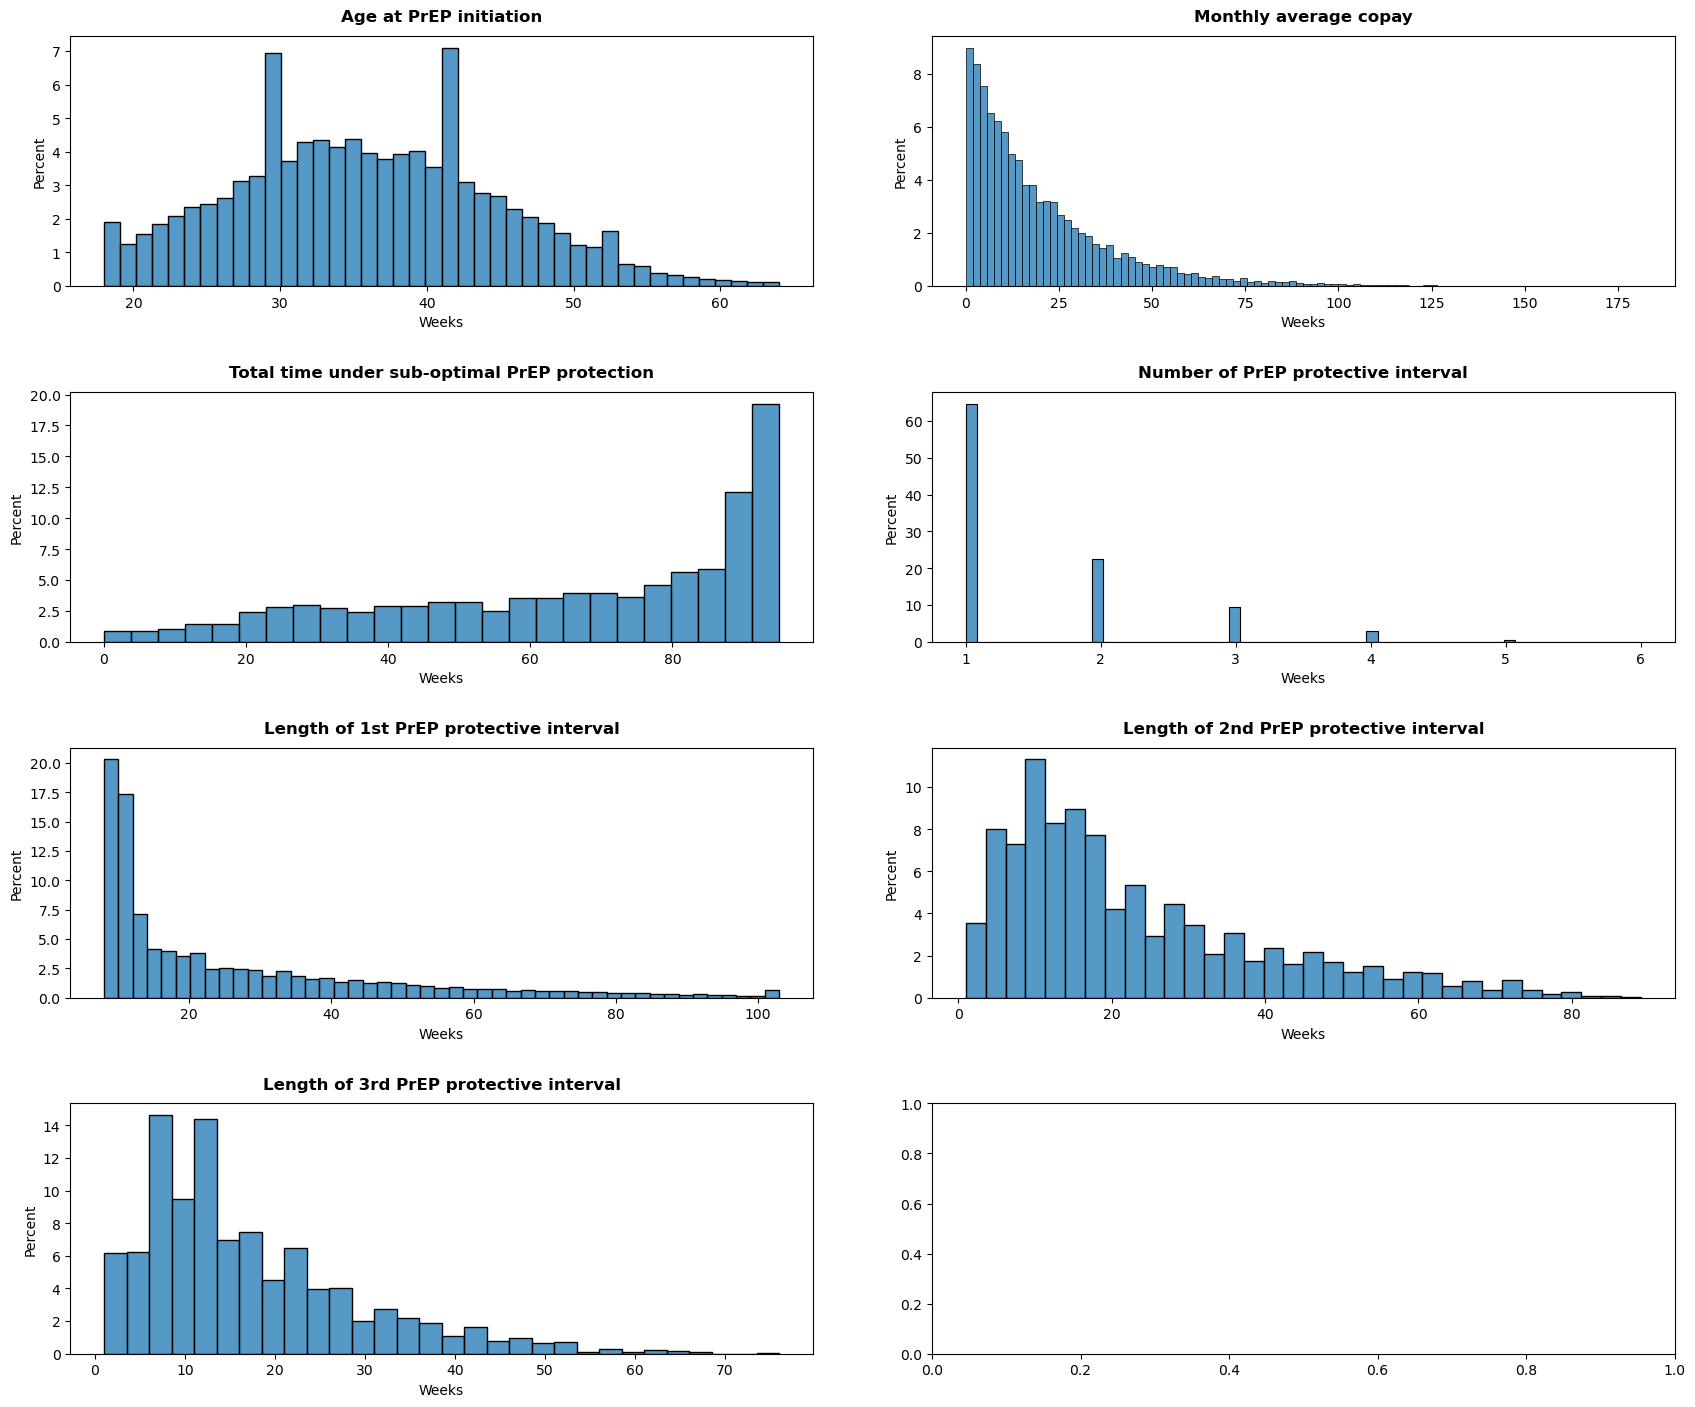

In [128]:
#univariate histograms
os.chdir(pr.here("./Figures"))

fig,ax =  plt.subplots(4,2,figsize=(18,15))
fig.tight_layout(pad=5.5)
col_arr=[0,1]*4
row_arr=np.repeat([0,1,2,3],2, axis=0)

for i in range(len(cont_vars)):
    plot=sns.histplot(data=PERSON_DATA,x=cont_vars[i],ax=ax[row_arr[i]][col_arr[i]],stat="percent")
    plot.set(xlabel="Weeks")
    plot.set_title(cont_vars_label[i],fontweight='bold', y=1.025)

plt.savefig('Univ_distplot_Orig.png', bbox_inches='tight')

### _Joint distributions_

In [129]:
#create new folder for joint distribution figures
os.chdir(pr.here("./Figures"))
print(User)

Emory


In [130]:
if "IntervalLen_1" in colnames:
    colnames.remove("IntervalLen_1")
    colnames.remove("IntervalLen_2")
    colnames.remove("IntervalLen_3")
joint_list=list(it.combinations(colnames,2))

colname_label={'Age_at_init':"Age at PrEP initiation",
'Primary_payer':"Primary payer",
'Average_copay':"Monthly average copay",
'Pharmacy_type':"Pharmacy type",
'Dur_subopt':'Total time under sub-optimal PrEP protection',
'Num_protect_interval':"Number of PrEP protective interval"}

PERSON_DATA["Age_at_init_cat"]=pd.cut(PERSON_DATA['Age_at_init'],
                                     bins=[18,24,29,39,49,max(PERSON_DATA['Age_at_init'])],
                                     include_lowest=True,
                                     labels=[1,2,3,4,5])

PERSON_DATA['Dur_subopt_cat']=pd.cut(PERSON_DATA['Dur_subopt'],
                                     bins=np.percentile(PERSON_DATA['Dur_subopt'],[0,33.3,66.7,100]),
                                     include_lowest=True,
                                     labels=[1,2,3])
if User == "Emory":
    PERSON_DATA['Num_protect_interval_cat']=pd.cut(PERSON_DATA['Num_protect_interval'],
                                         bins=[1,3,max(PERSON_DATA['Num_protect_interval'])],
                                         include_lowest=True,
                                         labels=[1,2])
    PERSON_DATA["Average_copay_cat"]=pd.cut(PERSON_DATA['Average_copay'],
                                     bins=[0,20,max(PERSON_DATA['Average_copay'])],
                                     include_lowest=True,
                                     labels=[1,2])
    
if User == "WG":
    PERSON_DATA['Num_protect_interval_cat']=pd.cut(PERSON_DATA['Num_protect_interval'],
                                         bins=[1,3,6,9,max(PERSON_DATA['Num_protect_interval'])],
                                         include_lowest=True,
                                         labels=[1,2,3,4])
    PERSON_DATA["Average_copay_cat"]=pd.cut(PERSON_DATA['Average_copay'],
                                     bins=[0,0.01,20,max(PERSON_DATA['Average_copay'])],
                                     include_lowest=True,
                                     labels=[1,2,3])

In [131]:
#Examine the categorical level for Num_protect_interval_cat and Average copay
print(PERSON_DATA["Num_protect_interval_cat"].value_counts())
print(PERSON_DATA["Average_copay_cat"].value_counts())

1    12564
2      436
Name: Num_protect_interval_cat, dtype: int64
1    8168
2    4832
Name: Average_copay_cat, dtype: int64


In [132]:
cat_levels={"Age_at_init_cat":[1,2,3,4,5],
            "Average_copay_cat":[1,2,3],
            'Dur_subopt_cat':[1,2,3],
            'Num_protect_interval_cat':[1,2],
            'Primary_payer': [0,1,2],
            'Pharmacy_type':[0,1]}

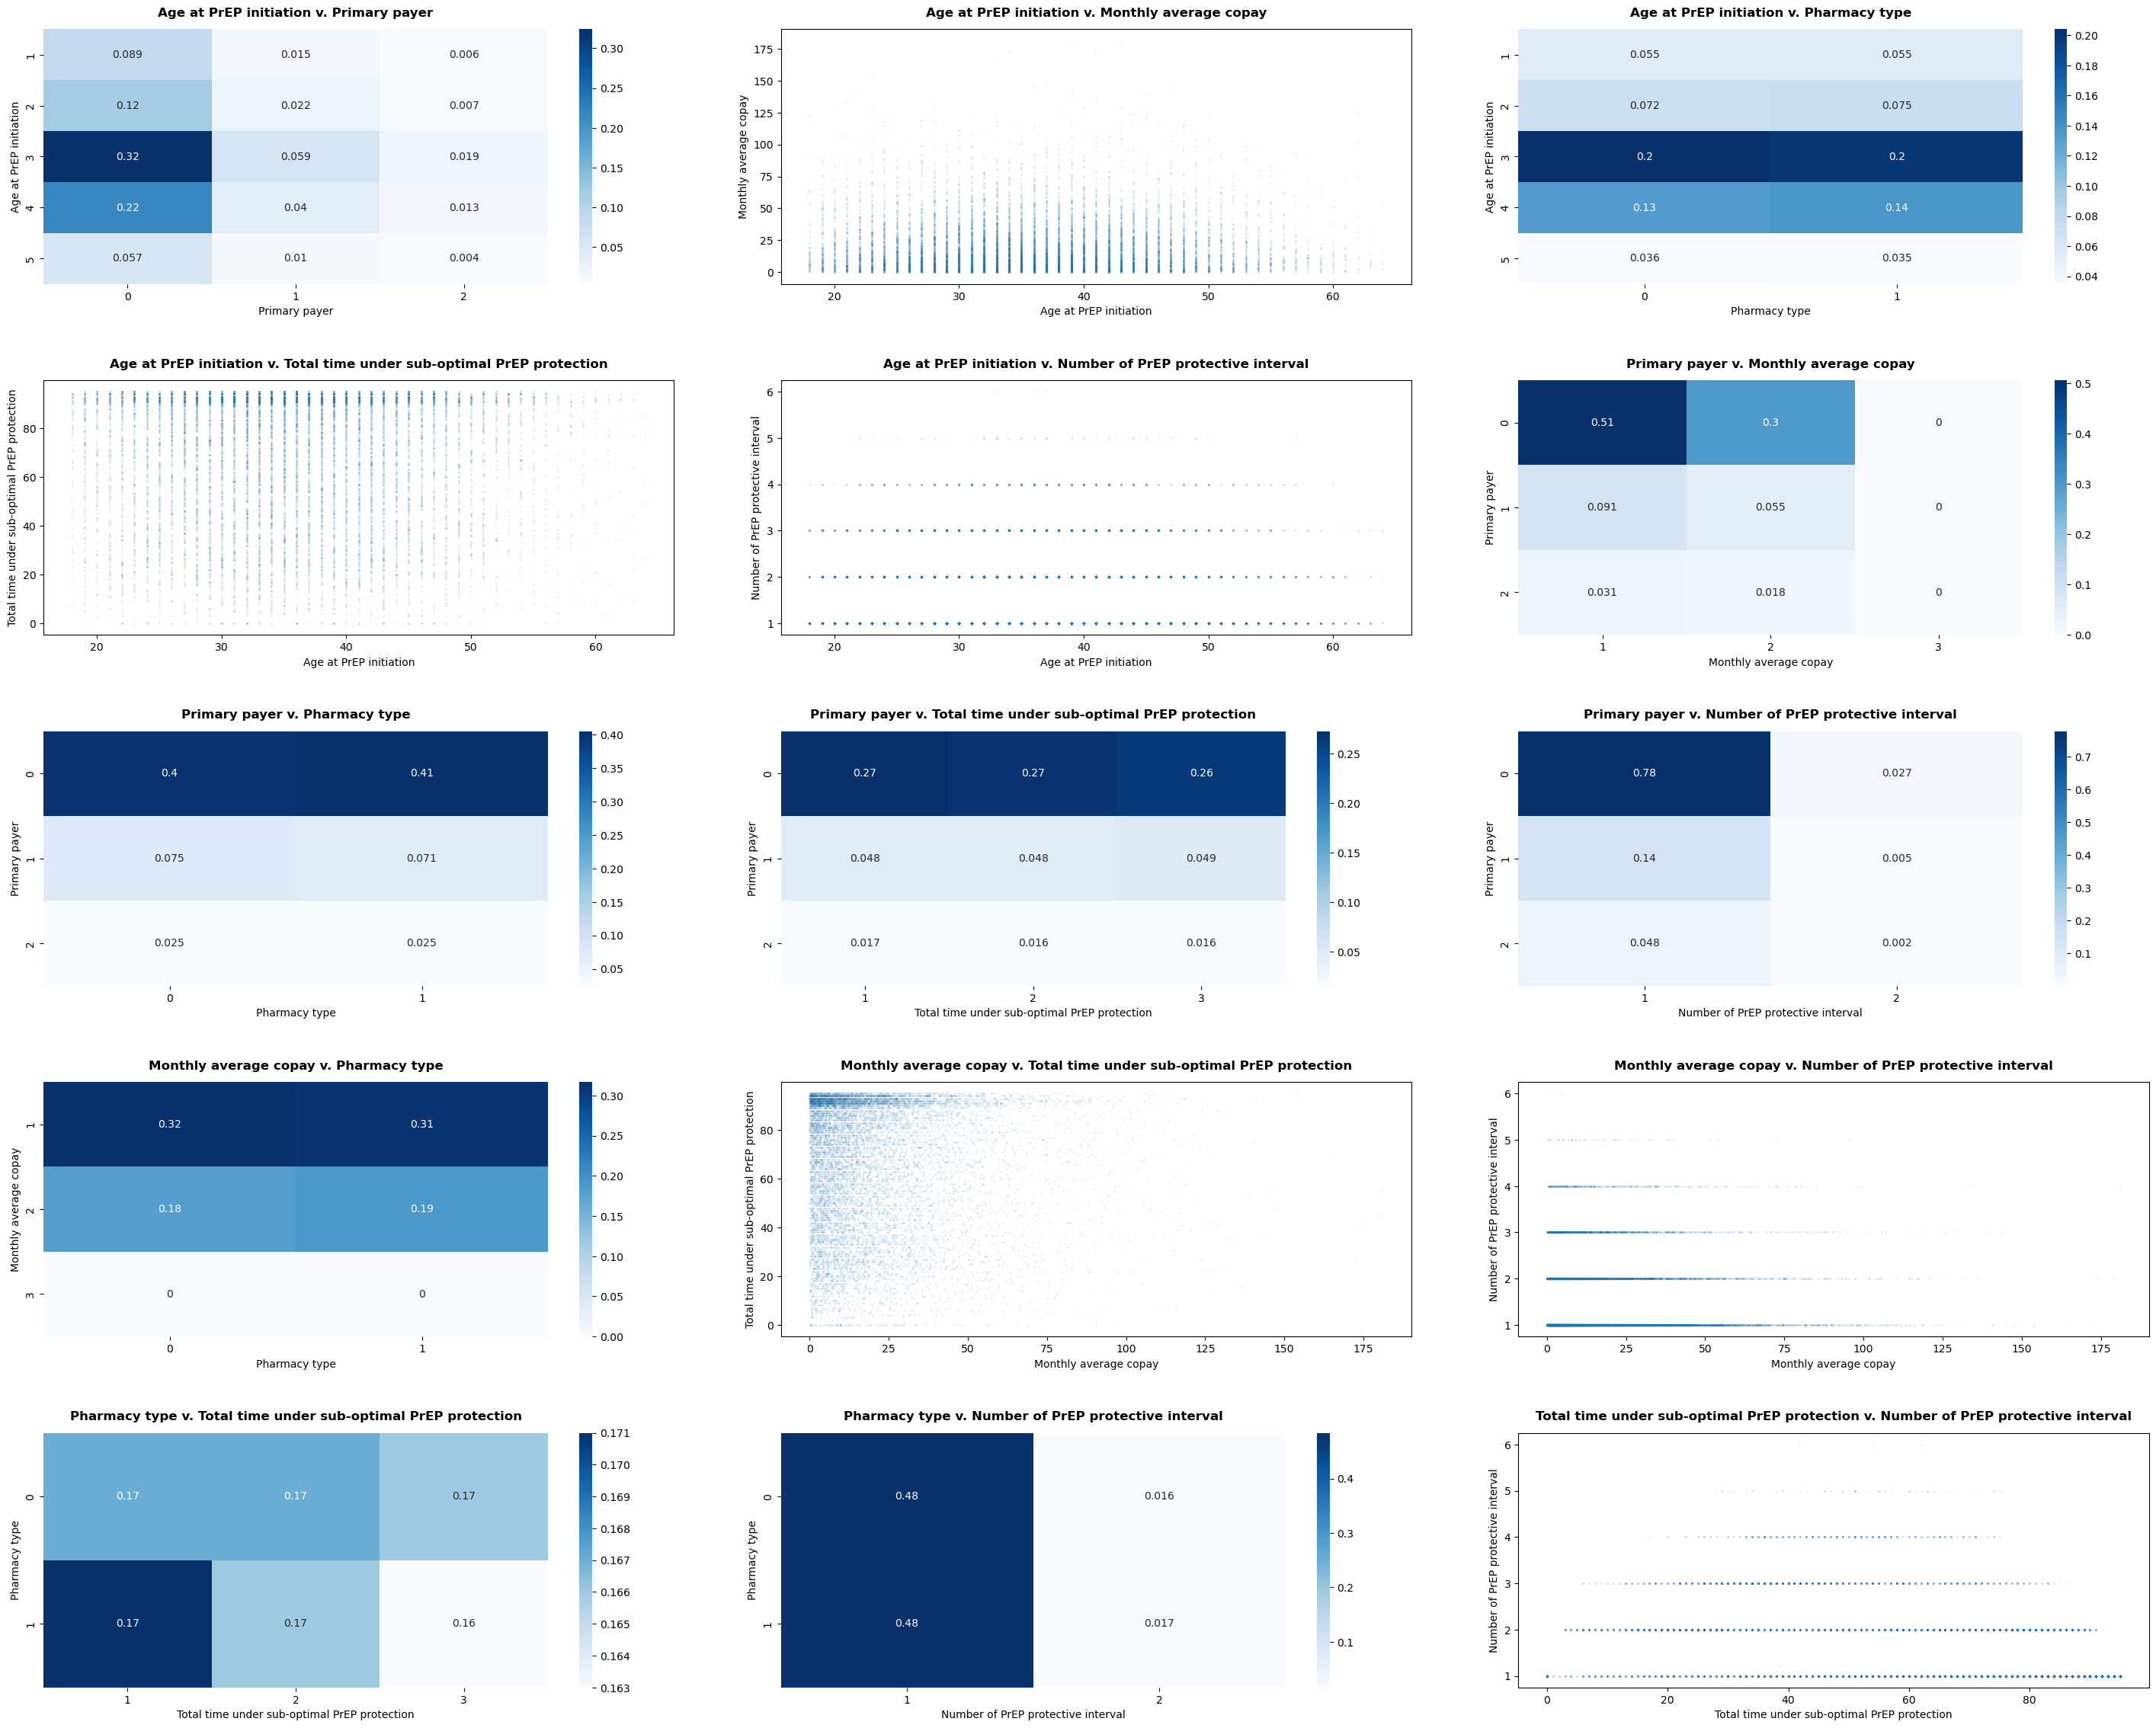

In [133]:
fig,ax =  plt.subplots(5,3,figsize=(30,24))
fig.tight_layout(pad=7)
col_arr=[0,1,2]*5
row_arr=np.repeat([0,1,2,3,4],3, axis=0)

joint_dist_stat=dict()

for i in range(len(joint_list)):
    X=joint_list[i][0]
    Y=joint_list[i][1]
    Xlabel=colname_label[X]
    Ylabel=colname_label[Y]
    TITLE=Xlabel+" v. "+Ylabel
    dict_title=X+ "/"+Y
    ##Both variables are continuous --> scatter plots
    if X in cont_vars and Y in cont_vars:
        joint_dist_stat[dict_title]=sc.stats.spearmanr(PERSON_DATA[X],PERSON_DATA[Y])[0]
        
        ax[row_arr[i]][col_arr[i]].scatter(PERSON_DATA[X],PERSON_DATA[Y],s=2,alpha=0.05)
        ax[row_arr[i]][col_arr[i]].set_title(TITLE,fontweight="bold",y=1.025)
        ax[row_arr[i]][col_arr[i]].set_xlabel(Xlabel)
        ax[row_arr[i]][col_arr[i]].set_ylabel(Ylabel)
    
    ##Both variables are categorical --> cross tabulation 
    if X in cat_vars and Y in cat_vars:
        ct=pd.crosstab(PERSON_DATA[X],PERSON_DATA[Y], rownames=[Xlabel],colnames=[Ylabel],dropna=True,normalize=True)
        ct = ct.reindex(index=cat_levels[X], columns=cat_levels[Y], fill_value=0)
        joint_dist_stat[dict_title]=ct
        
        plot=sns.heatmap(ct.round(3),cmap="Blues", annot=True, cbar=True, ax=ax[row_arr[i]][col_arr[i]])
        plot.set_title(TITLE,fontweight='bold', y=1.025)
        
    ##one variable is categorical and the other is continuous --> categorize the continuous variable and then cross tabulation 
    if X in cat_vars and Y in cont_vars:
        Y=Y+"_cat"
        ct=pd.crosstab(PERSON_DATA[X],PERSON_DATA[Y], rownames=[Xlabel],colnames=[Ylabel],dropna=True,normalize=True)
        ct = ct.reindex(index=cat_levels[X], columns=cat_levels[Y], fill_value=0)
        joint_dist_stat[dict_title]=ct
        
        plot=sns.heatmap(ct.round(3),cmap="Blues", annot=True, cbar=True,ax=ax[row_arr[i]][col_arr[i]])
        plot.set_title(TITLE,fontweight='bold', y=1.025)
        
    if Y in cat_vars and X in cont_vars:
        X=X+"_cat"
        ct=pd.crosstab(PERSON_DATA[X],PERSON_DATA[Y], rownames=[Xlabel],colnames=[Ylabel],dropna=True,normalize=True)
        ct = ct.reindex(index=cat_levels[X], columns=cat_levels[Y], fill_value=0)
        joint_dist_stat[dict_title]=ct
        
        plot=sns.heatmap(ct.round(3),cmap="Blues", annot=True, cbar=True,ax=ax[row_arr[i]][col_arr[i]])
        plot.set_title(TITLE,fontweight='bold', y=1.025)

plt.savefig('bivar_distplot_Orig.png', bbox_inches='tight')

In [134]:
# Obtain covarinace for continuous variable pairs
Cont_Data=PERSON_DATA[['Age_at_init','Average_copay','Dur_subopt','Num_protect_interval']]
Bivar_CoV=Cont_Data.cov()
Bivar_CoV

,Age_at_init,Average_copay,Dur_subopt,Num_protect_interval
Age_at_init,80.096305,-0.145614,-0.201939,0.107085
Average_copay,-0.145614,403.797201,-7.763542,0.090503
Dur_subopt,-0.201939,-7.763542,685.641544,-9.445645
Num_protect_interval,0.107085,0.090503,-9.445645,0.667060


## Export univariate/bivariate tables and appended covariate datasets

In [135]:
#Export descriptive statistics (original data) and other useful objects
os.chdir(pr.here("./Export"))
Descript_orig={"Univ. Continuous":univar_cont_orig, 
               "Univ. Categorical":univar_cat_orig, 
               "Bivar. Continuous CoV":Bivar_CoV,
               "colnames":colnames,
               "cont_vars":cont_vars,
               "cat_vars": cat_vars,
               "joint_list":joint_list,
               "joint_dist_stat":joint_dist_stat}
import pickle
pickle_out=open("Descript_orig","wb")
pickle.dump(Descript_orig,pickle_out)
pickle_out.close()

In [136]:
pickle_in=open("Descript_orig","rb")
loadobj=pickle.load(pickle_in)
Descript_orig2=loadobj
Descript_orig2

{'Univ. Continuous':                                       Attribute  Mean    SD  Median  IQR:25%  \
 0                        Age at PrEP initiation  35.9   8.9    35.0     29.0   
 1                         Monthly average copay  20.1  20.1    13.8      5.7   
 2  Total time under sub-optimal PrEP protection  65.9  26.2    73.0     46.0   
 3            Number of PrEP protective interval   1.5   0.8     1.0      1.0   
 4        Length of 1st PrEP protective interval  26.3  21.2    17.0     11.0   
 5        Length of 2nd PrEP protective interval  23.1  17.4    17.0     10.0   
 6        Length of 3rd PrEP protective interval  16.9  12.1    13.0      8.0   
 
    IQR:75%  
 0     42.0  
 1     27.9  
 2     91.0  
 3      2.0  
 4     35.0  
 5     32.0  
 6     23.0  ,
 'Univ. Categorical':                             Variable  Level      N     %
                        Primary payer      0  10464  80.5
                        Primary payer      1   1895  14.6
                      

In [137]:
os.chdir(pr.here("./Data"))
#Save the appended covariate dataset as csv 
PERSON_DATA.to_csv("PersonVars_appended.csv",index=False)
#Export the appended covariate dataset to pickle

import pickle
pickle_out=open("PersonVars_appended","wb")
pickle.dump(PERSON_DATA,pickle_out)
pickle_out.close()